In [ ]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["cartopy"]
_colab_install_missing_deps(deps)

# Calling R libraries from Python

Created: 2017-11-30

In this example we will explore the **Coral Reef Evaluation and Monitoring Project (CREMP)** data available in the **Gulf of Mexico Coastal Ocean Observing System (GCOOS)** ERDDAP server.

To access the server we will use the [`rerddap`](https://github.com/ropensci/rerddap) library and export the data to Python for easier plotting.

The first step is to load the `rpy2` extension that will allow us to use the `R` libraries.

In [1]:
%load_ext rpy2.ipython

The first line below has a `%%R` to make it an `R` cell. The code below specify the `GCOOS` server and fetches the data information for the [`fk_CREMP_yearly_revisited_DATA_v3_1996`](https://gcoos4.tamu.edu/erddap/tabledap/fk_CREMP_yearly_revisited_DATA_v3_1996.html) dataset.

For more information on `rerddap` please see [https://docs.ropensci.org/rerddap/](https://docs.ropensci.org/rerddap/).

In [2]:
%%R

library('rerddap')

url <- 'https://gcoos4.tamu.edu/erddap'
data_info <- rerddap::info('fk_CREMP_yearly_revisited_DATA_v3_1996', url=url)

data_info

<ERDDAP info> fk_CREMP_yearly_revisited_DATA_v3_1996 
 Base URL: https://gcoos4.tamu.edu/erddap 
 Dataset Type: tabledap 
 Variables:  
     acceptedNameAuthorship: 
     acceptedNameUsage: 
     acceptedNameUsageID: 
     averageNumberOfPoints: 
         Range: 407, 900 
         Units: count 
     basisOfRecord: 
     bottomType: 
     class: 
     country: 
     crs: 
     datasetID: 
     datasetName: 
     depth: 
         Range: 3.0, 54.0 
         Units: m 
     eventDate: 
         Range: 1996, 1996 
         Units: unknown 
     eventID: 
     family: 
     firstYear: 
         Range: 1996, 1996 
         Units: unknown 
     genus: 
     geodeticDatum: 
     habitat: 
     habitatID: 
     kingdom: 
     language: 
     latitude: 
         Range: 24.4517, 25.2953 
         Units: degrees_north 
     license: 
     locality: 
     longitude: 
         Range: -81.9195, -80.2087 
         Units: degrees_east 
     maximumDepthInMeters: 
         Range: 3.0, 54.0 
         Units:

By inspecting the information above we can find the variables available in the dataset and use  the `tabledap` function to download them.

Note that the `%%R -o rdf` will export the `rdf` variable back to the Python workspace.

In [3]:
%%R -o df

fields <- c(
    'depth',
    'longitude',
    'latitude',
    'organismQuantity',
    'genus',
    'habitat'
)

df <- tabledap(
    data_info,
    fields=fields,
    url=url
)

R[write to console]: info() output passed to x; setting base url to: https://gcoos4.tamu.edu/erddap



Now we need to export the `R` `DataFrame` to a `pandas` objects and ensure that all numeric types are numbers and not strings.

In [4]:
import pandas as pd

cols = ["longitude", "latitude", "depth", "organismQuantity"]
df[cols] = df[cols].apply(pd.to_numeric)

df.head()

,depth,longitude,latitude,organismQuantity,genus,habitat
2,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
3,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
4,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
5,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
6,9.0,-80.3782,25.1201,0.0,Acropora,Hard Bottom


We can navigate to ERDDAP's [info page](http://gcoos4.tamu.edu:8080/erddap/info/fk_CREMP_yearly_revisited_DATA_v3_1996/index.html) to find the variables description. Let's check what is `organismQuantity`:

```
The is value of the derived information product, such as the numerical value for biomass. This term does not include units. Mean number of observed fish per species for 5 Minutes
```

We can see that `organismQuantity` has a lot of zero values,
let's remove that first to plot the data positions only where something was found.

In [5]:
# Filter invalid values (-999).

cremp_1996 = df.loc[df["organismQuantity"] >= 0]
cremp_1996["genus"] = cremp_1996["genus"].str.strip()
cremp_1996.head()

,depth,longitude,latitude,organismQuantity,genus,habitat
2,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
3,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
4,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
5,6.0,-80.3475,25.1736,0.0,Acropora,Hard Bottom
6,9.0,-80.3782,25.1201,0.0,Acropora,Hard Bottom


What is the most common `genus` of Coral observed?

In [6]:
avg = cremp_1996.drop("habitat", axis=1).groupby("genus").mean()

avg

,depth,longitude,latitude,organismQuantity
genus,,,,
,23.2375,-81.046667,24.768958,0.034553
Acropora,23.2375,-81.046667,24.768957,0.006003
Agaricia,23.2375,-81.046667,24.768957,0.000005
Cladocora,23.2375,-81.046667,24.768957,0.000000
Colpophyllia,23.2375,-81.046667,24.768957,0.005079
Dendrogyra,23.2375,-81.046667,24.768957,0.001327
Diadema,23.2375,-81.046667,24.768957,0.000000
Dichocoenia,23.2375,-81.046667,24.768957,0.000591
Dictyota,23.2375,-81.046667,24.768957,0.000000


`rerddap`'s info request does not have enough metadata about the variables to explain the blank, and most abundant, `genus`. [Checking the sever](http://gcoos4.tamu.edu:8080/erddap/tabledap/fk_CREMP_yearly_revisited_DATA_v3_1996.html) did not help figure that out. We'll remove that for now to deal with only those that are identified.

In [7]:
cremp_1996 = cremp_1996.loc[cremp_1996["genus"] != ""]

There are also many `genus` with zero biomass count. In this example we'll choose to do a biased analysis of occurrence and eliminate those where nothing was observed.

In [8]:
# Filter zero values (nothing was observed).

cremp_1996 = cremp_1996.loc[cremp_1996["organismQuantity"] > 0]

Now we can check the `quantificationValue` average by `genus`.

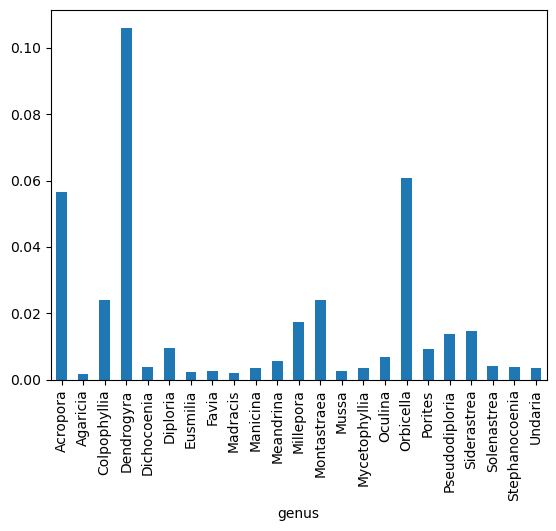

In [9]:
%matplotlib inline

avg = (
    cremp_1996.drop("habitat", axis=1).groupby("genus").mean()
)  # re-compute the "biased" average.
ax = avg["organismQuantity"].plot(kind="bar")

and `habitat`.

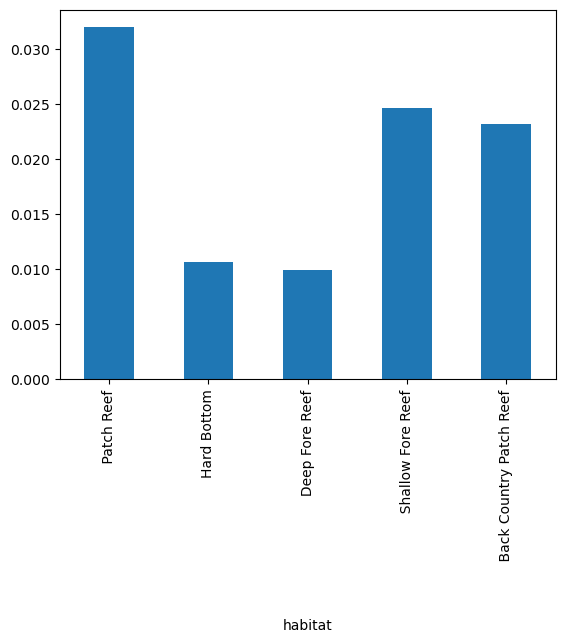

In [10]:
ax = (
    cremp_1996.drop("genus", axis=1)
    .groupby("habitat")
    .mean()["organismQuantity"]
    .plot(kind="bar")
)

It seems the most of the biomass was found around the `Dendrogyra` genus in Patch Reef habitats.
But where are those Coral Reefs? How is the distribution of top three species with more biomass around them?
With a `pandas` `DataFrame` it is easy to group the data by location and count the `genus` occurrence based on it.

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter


def make_plot():
    bbox = [-82, -80, 24, 26]
    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection=projection))

    ax.set_extent(bbox)

    land = cfeature.NaturalEarthFeature(
        "physical", "land", "10m", edgecolor="face", facecolor=[0.85] * 3
    )

    ax.add_feature(land, zorder=0)
    ax.coastlines("10m", zorder=1)

    ax.set_xticks(np.linspace(bbox[0], bbox[1], 3), crs=projection)
    ax.set_yticks(np.linspace(bbox[2], bbox[3], 3), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return fig, ax

/tmp/ipykernel_9861/710676339.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("viridis_r", 6),


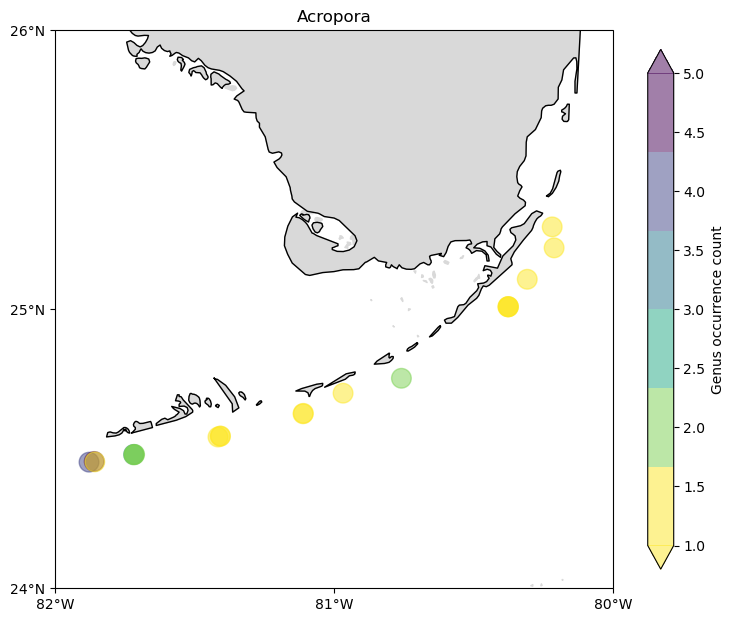

In [12]:
count = (
    cremp_1996.loc[cremp_1996["genus"] == "Acropora"]
    .groupby(["longitude", "latitude"])
    .count()
    .reset_index()
)


fig, ax = make_plot()
c = ax.scatter(
    count["longitude"],
    count["latitude"],
    s=200,
    c=count["genus"],
    alpha=0.5,
    cmap=plt.cm.get_cmap("viridis_r", 6),
    zorder=3,
)
cbar = fig.colorbar(c, shrink=0.75, extend="both")
cbar.ax.set_ylabel("Genus occurrence count")
ax.set_title("Acropora");

/tmp/ipykernel_9861/1312933967.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("viridis_r", 6),


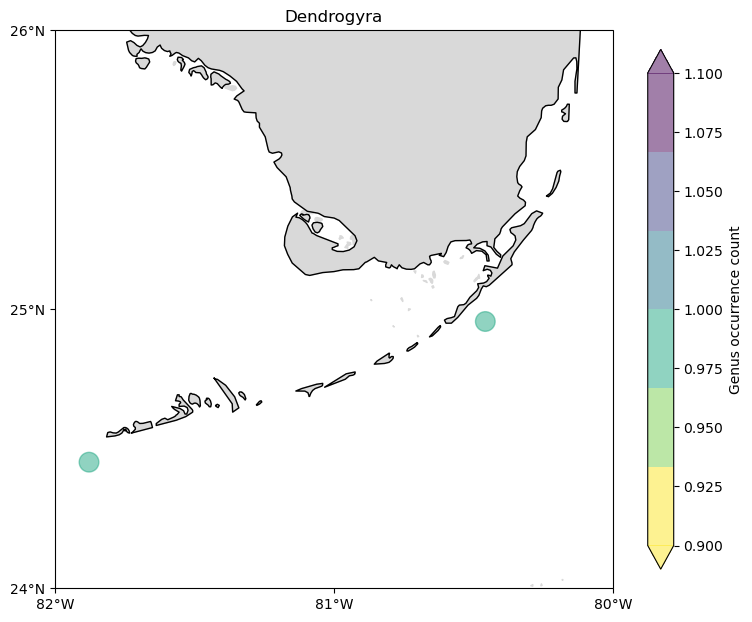

In [13]:
count = (
    cremp_1996.loc[cremp_1996["genus"] == "Dendrogyra"]
    .groupby(["longitude", "latitude"])
    .count()
    .reset_index()
)


fig, ax = make_plot()
c = ax.scatter(
    count["longitude"],
    count["latitude"],
    s=200,
    c=count["genus"],
    alpha=0.5,
    cmap=plt.cm.get_cmap("viridis_r", 6),
    zorder=3,
)
cbar = fig.colorbar(c, shrink=0.75, extend="both")
cbar.ax.set_ylabel("Genus occurrence count")
ax.set_title("Dendrogyra");

/tmp/ipykernel_9861/1632937538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("viridis_r", 6),


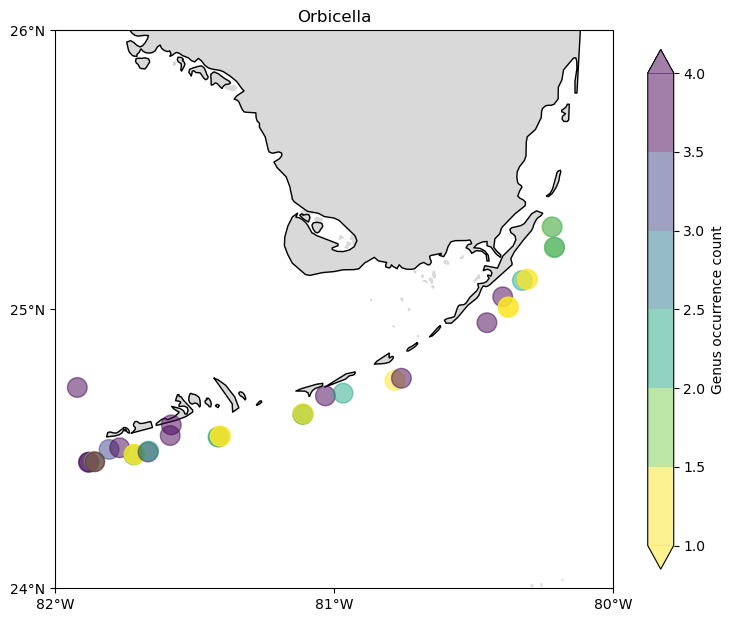

In [14]:
count = (
    cremp_1996.loc[cremp_1996["genus"] == "Orbicella"]
    .groupby(["longitude", "latitude"])
    .count()
    .reset_index()
)


fig, ax = make_plot()
c = ax.scatter(
    count["longitude"],
    count["latitude"],
    s=200,
    c=count["genus"],
    alpha=0.5,
    cmap=plt.cm.get_cmap("viridis_r", 6),
    zorder=3,
)
cbar = fig.colorbar(c, shrink=0.75, extend="both")
cbar.ax.set_ylabel("Genus occurrence count")
ax.set_title("Orbicella");

This demonstration showed the power of mixing `Python` and `R` to reduce developer time and allow the research to focus on the data and not the programming language.